In [7]:
%%html
<marquee style='width: 90%; color: blue;'><b>INSTITUTO INFNET | ESCOLA SUPERIOR DA
TECNOLOGIA DA INFORMAÇÃO</b></marquee>

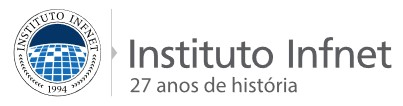

### Pós-graduação MIT em Inteligência Artificial, Machine Learning \& Deep Learning
Bloco: Aprendizado de Dados em Tempo Real [23E1-23E1] 

Disciplina: Algoritmos supervisionados para classificação [23E1_2] 

Docente: Felipe Fink Grael

Aluno: Winicius Botelho Faquieri

---

In [9]:
# Bibliotecas:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, accuracy_score, precision_score,f1_score
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, cross_val_predict, ShuffleSplit
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn import model_selection
from IPython.display import display
import warnings

In [6]:
# Configurações
pd.options.display.max_columns = None 
np.random.seed(10)
seed = 10
warnings.filterwarnings("ignore")
sns.set_palette("Set2")
sns.set_style("whitegrid")

#### Definindo funções uteis

In [7]:
# Cria um gráfico com as matrizes de confusão de treino e de teste
def cf_plot(clf, X_train, X_test, y_train, y_test, method):
    acc_train = clf.score(X_train, y_train)
    acc_test = clf.score(X_test, y_test)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    cf_matrix_train = confusion_matrix(y_train, y_pred_train, normalize='true')
    cf_matrix_test = confusion_matrix(y_test, y_pred_test, normalize='true')
    disp_cf_matrix_train = ConfusionMatrixDisplay(
        cf_matrix_train, display_labels=['Not churn', 'Churn'])
    disp_cf_matrix_test = ConfusionMatrixDisplay(
        cf_matrix_test, display_labels=['Not churn', 'Churn'])
    f, axes = plt.subplots(1, 2, figsize=(15, 10), sharey='row')
    disp_cf_matrix_train.plot(ax=axes[0], cmap='Blues')
    disp_cf_matrix_train.ax_.set_xlabel(
        'Predicted label\naccuracy={:0.4f}'.format(acc_train)
                                        )
    disp_cf_matrix_test.plot(ax=axes[1], cmap='Blues')
    disp_cf_matrix_test.ax_.set_xlabel(
        'Predicted label\naccuracy={:0.4f}'.format(acc_test)
                                        )
    title_train = method+' (Train)'
    title_test = method+' (Test)'
    disp_cf_matrix_train.ax_.set_title(title_train)
    disp_cf_matrix_test.ax_.set_title(title_test)
    disp_cf_matrix_train.im_.colorbar.remove()
    disp_cf_matrix_test.im_.colorbar.remove()
    plt.show()

In [8]:
# Modelos de aprendizado de máquina treinam automaticamente e avaliam
def models_score(models, X_train, y_train, X_test, y_test, scoring = 'accuracy', n_splits=10, figsize = (20, 4)):
  results_cv = []
  results = []
  names = []
  best_test_f1 = 0
  best_clf = ''
  for name, model in models:
    names.append(name)
    # cross validation
    kfold = model_selection.KFold(n_splits=n_splits)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results_cv.append(cv_results) # acc cv
    # model training
    time1 = datetime.datetime.now()
    model.fit(X_train, y_train)
    time2 = datetime.datetime.now()
    # model predict
    x_pred_train = model.predict(X_train)
    x_pred_test = model.predict(X_test)
    # accuracy
    train_acc = round(model.score(X_train,y_train),10)
    test_acc = round(model.score(X_test,y_test),10)
    # score recall 
    score_recall_train = round(recall_score(x_pred_train,y_train),10)
    score_recall_test = round(recall_score(x_pred_test,y_test),10)
    # score precision
    score_precision_train = round(precision_score(x_pred_train,y_train),10)
    score_precision_test = round(precision_score(x_pred_test,y_test),10)
    # f1 score
    score_f1_train = round(f1_score(x_pred_train,y_train),10)
    score_f1_test = round(f1_score(x_pred_test,y_test),10)  
    if score_f1_test > best_test_f1:
      best_test_f1 = score_f1_test
      best_clf = model
      best_name = name
    # training time
    duration=time2-time1 
    # df
    results.append({'Name': name, 
                       'CV Acc (train)': np.mean(cv_results),
                       'Accuracy (train)': train_acc,
                       'Accuracy (test)': test_acc,
                       'Train Acc Stability': np.abs(train_acc - np.mean(cv_results)),
                       'Train/Test Acc Stability': np.abs(test_acc - train_acc),
                       'Recall (train)': score_recall_train,
                       'Recall (test)': score_recall_test,
                       'Precision (train)': score_precision_train,
                       'Precision (test)': score_precision_test,
                       'F1-score (train)': score_f1_train,
                       'F1-score (test)': score_f1_test,             
                       'Training time (s)': duration.total_seconds()})
  results_df = pd.DataFrame(results).sort_values(by='F1-score (test)', ascending=False).reset_index(drop = True)
  results_cv_df = pd.DataFrame(results_cv).T
  results_cv_df.columns = names
  print('----------------RESULTS-------------- \n')
  print('Best accuracy in train (CV mean): {:0.2f}'.format(np.max(np.mean(results_cv, axis=1))))
  print('Best accuracy in test: {:0.2f}'.format(results_df['Accuracy (test)'].max()))
  print('Best f1-score in test: {:0.2f} \n'.format(results_df['F1-score (test)'].max()))
  print('\n-------------BEST CONFUSION MATRIX (F1-SCORE TEST)----------- \n')
  cf_plot(best_clf, X_train, X_test, y_train, y_test, best_name)
  print('-----------MODELS COMPARISON--------- \n')
  display(results_df)
  print('\n-------------VIZUALIZATION----------- \n')
  comparison_visualization(results_cv_df, results_df, figsize)
  return results_cv_df, results_df

In [9]:
def comparison_visualization(results_cv_df, results_test, figsize = (20, 4)):
  fig, axs = plt.subplots(1, 2, figsize=figsize)
  sns.boxplot(data=results_cv_df.reindex(columns=list(results_test['Name'])), ax=axs[0]).set(xlabel='Algorithm', ylabel='Avg accuracy' )
  axs[0].title.set_text('Train CV accuracy results')
  sns.barplot(x = 'Name',y = 'Accuracy (test)', data = results_test, ax=axs[1]).set(xlabel='Algorithm', ylabel='Accuracy' )
  axs[1].title.set_text('Test accuracy results')
  plt.show()

In [10]:
def optimizer(model, param_dict, seed, X_train, y_train, verbose= 0, n_iter = 10, scoring = 'accuracy', cv = 5):
  random_search = RandomizedSearchCV(model, param_distributions=param_dict, n_iter=n_iter, n_jobs = -1, cv = cv, verbose = verbose, scoring = scoring, random_state=seed)
  random_search.fit(X_train, y_train)
  best_params = random_search.best_params_
  best_score = random_search.best_score_
  print(f'The best found score was:{best_score} \n')
  print(f'The best found params were:{best_params} \n')
  return best_params, best_score

In [11]:
def color_red(val):
    color = 'red' if np.abs(val) <= 0.105 else 'black'
    return 'color: %s' % color

---

In [10]:
# Leitura dos dados
data = pd.read_csv('data/preprocessed_Telco_churn_data.csv', sep = ';', index_col=0) # reading data from csv
data.head() # show first 5 lines

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,...,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetTechnology_DSL,InternetTechnology_Fiber optic,tenure_group_1,tenure_group_2,tenure_group_3,tenure_group_4,tenure_group_5+
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0,1,0,1,0,0.0,1,0.0,1.0,0.0,...,0,1,0,1,0,1,0,0,0,0
5575-GNVDE,0,0,0,34,1,0.0,1,1.0,0.0,1.0,...,0,0,1,1,0,0,0,1,0,0
3668-QPYBK,0,0,0,2,1,0.0,1,1.0,1.0,0.0,...,0,0,1,1,0,1,0,0,0,0
7795-CFOCW,0,0,0,45,0,0.0,1,1.0,0.0,1.0,...,0,0,0,1,0,0,0,0,1,0
9237-HQITU,0,0,0,2,1,0.0,1,0.0,0.0,0.0,...,0,1,0,0,1,1,0,0,0,0


In [16]:
data['MonthlyCharges'].unique()

array([29.85, 56.95, 53.85, ..., 63.1 , 44.2 , 78.7 ])

In [18]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.00,0.00,0.00,1.00
Partner,7043.0,0.483033,0.499748,0.00,0.00,0.00,1.00,1.00
Dependents,7043.0,0.299588,0.458110,0.00,0.00,0.00,1.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.00,29.00,55.00,72.00
PhoneService,7043.0,0.903166,0.295752,0.00,1.00,1.00,1.00,1.00
MultipleLines,7043.0,0.421837,0.493888,0.00,0.00,0.00,1.00,1.00
InternetService,7043.0,0.783331,0.412004,0.00,1.00,1.00,1.00,1.00
OnlineSecurity,7043.0,0.286668,0.452237,0.00,0.00,0.00,1.00,1.00
OnlineBackup,7043.0,0.344881,0.475363,0.00,0.00,0.00,1.00,1.00
DeviceProtection,7043.0,0.343888,0.475038,0.00,0.00,0.00,1.00,1.00


In [14]:
print('The dataset has', data.shape[0], 'lines (customers) and', data.shape[1], 'variables (attributes)')

The dataset has 7043 lines (customers) and 32 variables (attributes)


In [18]:
train_columns = list(data.columns) # cria uma lista com o nome dos atributos
train_columns_tenure = [e for e in train_columns if e not in ('Churn', 'tenure')]
train_columns = [e for e in train_columns if e not in ('Churn', 'tenure_group_1', 'tenure_group_2', 'tenure_group_3', 'tenure_group_4', 'tenure_group_5+')]

In [19]:
# original train/test dataset (with tenure as numerical)
X_train, X_test, y_train, y_test = train_test_split(
    data[train_columns], data['Churn'], test_size=0.3, random_state=seed, stratify=data['Churn']
                                                    )

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (4930, 26)
Number transactions y_train dataset:  (4930,)
Number transactions X_test dataset:  (2113, 26)
Number transactions y_test dataset:  (2113,)


In [20]:
# train/test dataset (with tenure as categorical)
X_train_tenure, X_test_tenure, y_train_tenure, y_test_tenure = train_test_split(
    data[train_columns_tenure], data['Churn'], test_size=0.3, random_state=seed, stratify=data['Churn']
                                                    )

print("Number transactions X_train dataset: ", X_train_tenure.shape)
print("Number transactions y_train dataset: ", y_train_tenure.shape)
print("Number transactions X_test dataset: ", X_test_tenure.shape)
print("Number transactions y_test dataset: ", y_test_tenure.shape)

Number transactions X_train dataset:  (4930, 30)
Number transactions y_train dataset:  (4930,)
Number transactions X_test dataset:  (2113, 30)
Number transactions y_test dataset:  (2113,)


In [21]:
#2.3 Normalization
X_train_bckp = X_train.copy()
X_test_bckp = X_test.copy()
mm_scaler = preprocessing.MinMaxScaler() # scaler

# original dataset
X_train = mm_scaler.fit_transform(X_train)
X_test = mm_scaler.transform(X_test)

# dataset with tenure as categorical
X_train_tenure = mm_scaler.fit_transform(X_train_tenure)
X_test_tenure = mm_scaler.transform(X_test_tenure)

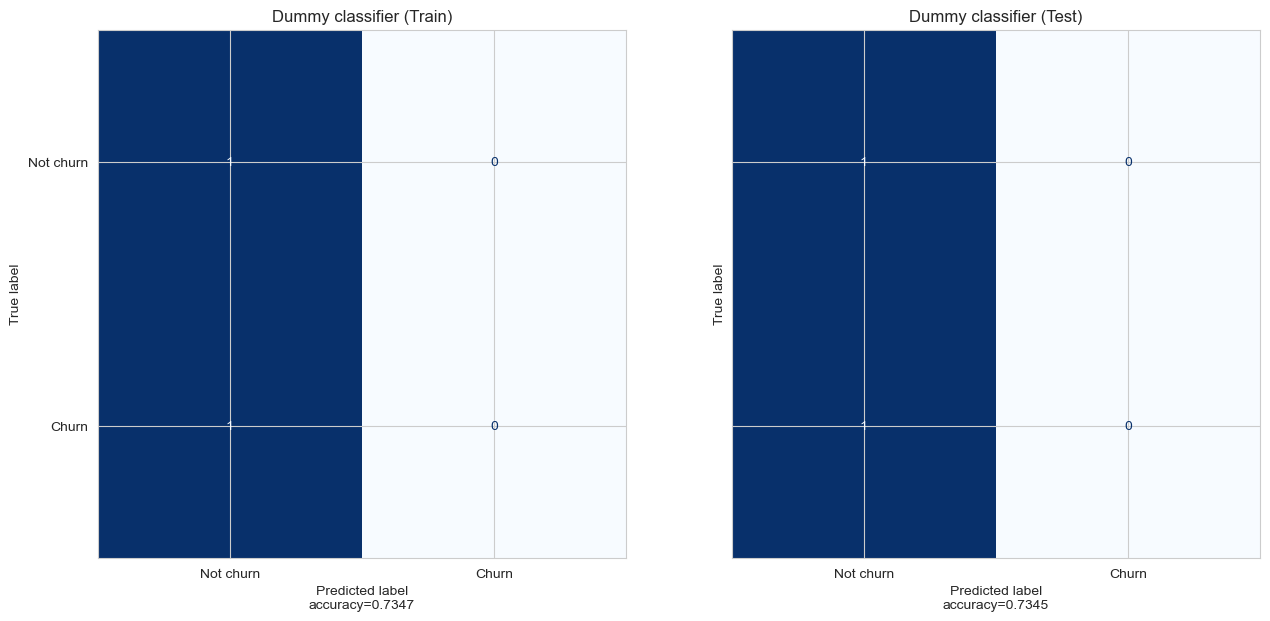

In [22]:
dummy_clf = DummyClassifier(strategy="most_frequent") # dummy classifier with most frequent value strategy
dummy_clf.fit(X_train, y_train)
cf_plot(dummy_clf, X_train, X_test, y_train, y_test, 'Dummy classifier')

In [23]:
# list the models to be used
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('DT', DecisionTreeClassifier(random_state=seed)))
models.append(('SVM', SVC(random_state=seed)))

----------------RESULTS-------------- 

Best accuracy in train (CV mean): 0.81
Best accuracy in test: 0.79
Best f1-score in test: 0.57 


-------------BEST CONFUSION MATRIX (F1-SCORE TEST)----------- 



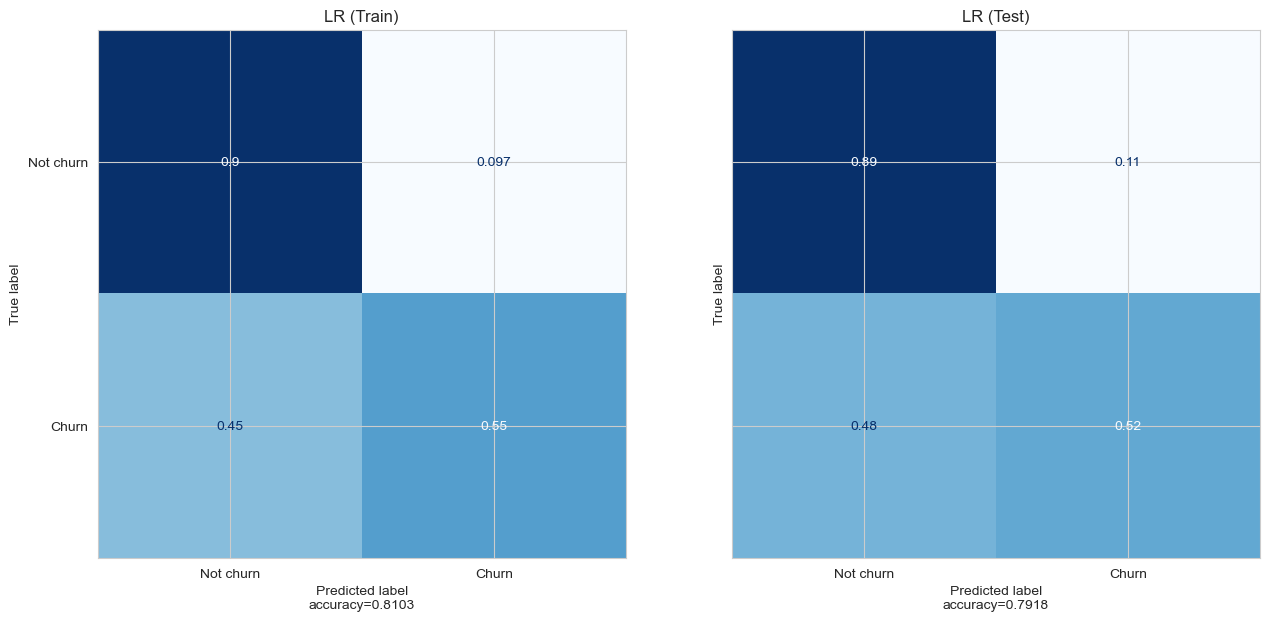

-----------MODELS COMPARISON--------- 



,Name,CV Acc (train),Accuracy (train),Accuracy (test),Train Acc Stability,Train/Test Acc Stability,Recall (train),Recall (test),Precision (train),Precision (test),F1-score (train),F1-score (test),Training time (s)
0,LR,0.809128,0.810345,0.791765,0.001217,0.01858,0.673166,0.631236,0.554281,0.518717,0.607966,0.569472,0.037030
1,SVM,0.802840,0.825152,0.789872,0.022312,0.03528,0.723447,0.639618,0.551988,0.477718,0.626193,0.546939,0.564524
2,DT,0.731034,0.997769,0.724089,0.266734,0.27368,0.999230,0.480969,0.992355,0.495544,0.995781,0.488147,0.016703



-------------VIZUALIZATION----------- 



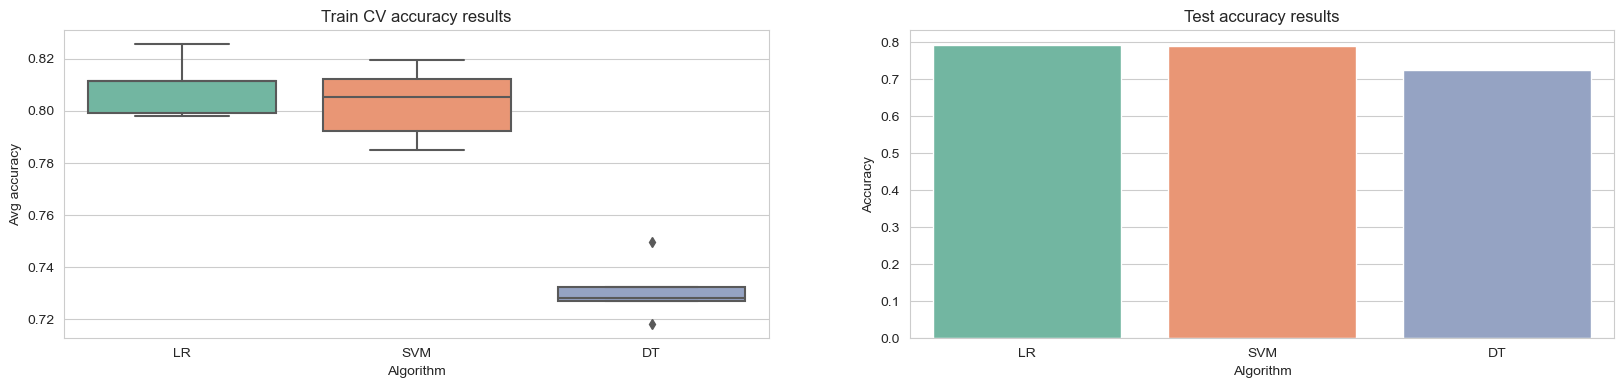

In [24]:
results_cv_df_1, results_df_1 = models_score(models, X_train, y_train, X_test, y_test, scoring = 'accuracy', n_splits=5)